# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 400
LEARNING_RATE = 0.001
BATCH_SIZE = 128
ACTIVATION = "tanh"
N_HIDDEN = [128, 64, 32]
REGULARIZER = keras.regularizers.l2(0.001)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name


def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture2()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/400
101/101 [==============================] - 2s 6ms/step - loss: 0.9968 - categorical_accuracy: 0.6208 - val_loss: 0.8546 - val_categorical_accuracy: 0.6805
Epoch 2/400
101/101 [==============================] - 0s 5ms/step - loss: 0.8139 - categorical_accuracy: 0.6969 - val_loss: 0.8221 - val_categorical_accuracy: 0.6768
Epoch 3/400
101/101 [==============================] - 0s 5ms/step - loss: 0.7723 - categorical_accuracy: 0.7101 - val_loss: 0.7717 - val_categorical_accuracy: 0.7022
Epoch 4/400
101/101 [==============================] - 0s 5ms/step - loss: 0.7202 - categorical_accuracy: 0.7302 - val_loss: 0.7089 - val_categorical_accuracy: 0.7295
Epoch 5/400
101/101 [==============================] - 0s 5ms/step - loss: 0.6731 - categorical_accuracy: 0.7485 - val_loss: 0.6670 - val_categorical_accuracy: 0.7475
Epoch 6/400
101/101 [==============================] - 0s 5ms/step - loss: 0.6367 - categorical_accuracy: 0.7676 - val_loss: 0.6438 - val_categorical_accuracy: 0.752

Epoch 50/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4873 - categorical_accuracy: 0.8035 - val_loss: 0.5137 - val_categorical_accuracy: 0.7854
Epoch 51/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4894 - categorical_accuracy: 0.8055 - val_loss: 0.5113 - val_categorical_accuracy: 0.7798
Epoch 52/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4881 - categorical_accuracy: 0.8037 - val_loss: 0.5046 - val_categorical_accuracy: 0.7854
Epoch 53/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4842 - categorical_accuracy: 0.8040 - val_loss: 0.5017 - val_categorical_accuracy: 0.7940
Epoch 54/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4843 - categorical_accuracy: 0.8058 - val_loss: 0.4975 - val_categorical_accuracy: 0.7953
Epoch 55/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4874 - categorical_accuracy: 0.8045 - val_loss: 0.5132 - val_categorical_accuracy:

Epoch 99/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4729 - categorical_accuracy: 0.8076 - val_loss: 0.4861 - val_categorical_accuracy: 0.8009
Epoch 100/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4718 - categorical_accuracy: 0.8085 - val_loss: 0.4997 - val_categorical_accuracy: 0.7872
Epoch 101/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4735 - categorical_accuracy: 0.8088 - val_loss: 0.4999 - val_categorical_accuracy: 0.7878
Epoch 102/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4745 - categorical_accuracy: 0.8086 - val_loss: 0.4895 - val_categorical_accuracy: 0.7996
Epoch 103/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4738 - categorical_accuracy: 0.8056 - val_loss: 0.4852 - val_categorical_accuracy: 0.8065
Epoch 104/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4708 - categorical_accuracy: 0.8085 - val_loss: 0.5000 - val_categorical_accu

101/101 [==============================] - 1s 6ms/step - loss: 0.4587 - categorical_accuracy: 0.8158 - val_loss: 0.4844 - val_categorical_accuracy: 0.8040
Epoch 148/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4617 - categorical_accuracy: 0.8114 - val_loss: 0.4771 - val_categorical_accuracy: 0.8052
Epoch 149/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4598 - categorical_accuracy: 0.8134 - val_loss: 0.4833 - val_categorical_accuracy: 0.7897
Epoch 150/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4605 - categorical_accuracy: 0.8121 - val_loss: 0.4912 - val_categorical_accuracy: 0.7872
Epoch 151/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4606 - categorical_accuracy: 0.8132 - val_loss: 0.4832 - val_categorical_accuracy: 0.7940
Epoch 152/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4604 - categorical_accuracy: 0.8132 - val_loss: 0.4764 - val_categorical_accuracy: 0.8009


101/101 [==============================] - 1s 6ms/step - loss: 0.4555 - categorical_accuracy: 0.8144 - val_loss: 0.4774 - val_categorical_accuracy: 0.8077
Epoch 196/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4534 - categorical_accuracy: 0.8173 - val_loss: 0.4798 - val_categorical_accuracy: 0.8052
Epoch 197/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4541 - categorical_accuracy: 0.8153 - val_loss: 0.4746 - val_categorical_accuracy: 0.7996
Epoch 198/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4523 - categorical_accuracy: 0.8174 - val_loss: 0.4800 - val_categorical_accuracy: 0.7990
Epoch 199/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4525 - categorical_accuracy: 0.8169 - val_loss: 0.4731 - val_categorical_accuracy: 0.8052
Epoch 200/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4536 - categorical_accuracy: 0.8181 - val_loss: 0.4746 - val_categorical_accuracy: 0.8021


101/101 [==============================] - 1s 6ms/step - loss: 0.4487 - categorical_accuracy: 0.8179 - val_loss: 0.4728 - val_categorical_accuracy: 0.8040
Epoch 244/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4508 - categorical_accuracy: 0.8177 - val_loss: 0.4666 - val_categorical_accuracy: 0.8114
Epoch 245/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4489 - categorical_accuracy: 0.8186 - val_loss: 0.4719 - val_categorical_accuracy: 0.8009
Epoch 246/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4505 - categorical_accuracy: 0.8161 - val_loss: 0.4859 - val_categorical_accuracy: 0.7978
Epoch 247/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4519 - categorical_accuracy: 0.8172 - val_loss: 0.4773 - val_categorical_accuracy: 0.7928
Epoch 248/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4491 - categorical_accuracy: 0.8187 - val_loss: 0.4771 - val_categorical_accuracy: 0.7978


101/101 [==============================] - 1s 7ms/step - loss: 0.4480 - categorical_accuracy: 0.8179 - val_loss: 0.4680 - val_categorical_accuracy: 0.8015
Epoch 292/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4490 - categorical_accuracy: 0.8187 - val_loss: 0.4666 - val_categorical_accuracy: 0.8071
Epoch 293/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4458 - categorical_accuracy: 0.8176 - val_loss: 0.4659 - val_categorical_accuracy: 0.8058
Epoch 294/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4477 - categorical_accuracy: 0.8158 - val_loss: 0.4672 - val_categorical_accuracy: 0.8040
Epoch 295/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4503 - categorical_accuracy: 0.8155 - val_loss: 0.4734 - val_categorical_accuracy: 0.8033
Epoch 296/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4485 - categorical_accuracy: 0.8168 - val_loss: 0.4665 - val_categorical_accuracy: 0.8040


101/101 [==============================] - 1s 6ms/step - loss: 0.4486 - categorical_accuracy: 0.8177 - val_loss: 0.4646 - val_categorical_accuracy: 0.8083
Epoch 340/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4456 - categorical_accuracy: 0.8176 - val_loss: 0.4675 - val_categorical_accuracy: 0.8046
Epoch 341/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4459 - categorical_accuracy: 0.8194 - val_loss: 0.4627 - val_categorical_accuracy: 0.8096
Epoch 342/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4464 - categorical_accuracy: 0.8194 - val_loss: 0.4628 - val_categorical_accuracy: 0.8089
Epoch 343/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4471 - categorical_accuracy: 0.8193 - val_loss: 0.4688 - val_categorical_accuracy: 0.8040
Epoch 344/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4434 - categorical_accuracy: 0.8202 - val_loss: 0.4765 - val_categorical_accuracy: 0.7953


101/101 [==============================] - 1s 6ms/step - loss: 0.4424 - categorical_accuracy: 0.8196 - val_loss: 0.4659 - val_categorical_accuracy: 0.8052
Epoch 388/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4427 - categorical_accuracy: 0.8188 - val_loss: 0.4662 - val_categorical_accuracy: 0.8071
Epoch 389/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4442 - categorical_accuracy: 0.8177 - val_loss: 0.4638 - val_categorical_accuracy: 0.8040
Epoch 390/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4432 - categorical_accuracy: 0.8179 - val_loss: 0.4622 - val_categorical_accuracy: 0.8071
Epoch 391/400
101/101 [==============================] - 1s 6ms/step - loss: 0.4442 - categorical_accuracy: 0.8197 - val_loss: 0.4649 - val_categorical_accuracy: 0.8046
Epoch 392/400
101/101 [==============================] - 1s 7ms/step - loss: 0.4440 - categorical_accuracy: 0.8203 - val_loss: 0.4674 - val_categorical_accuracy: 0.8083


## Step 7: Analyze results

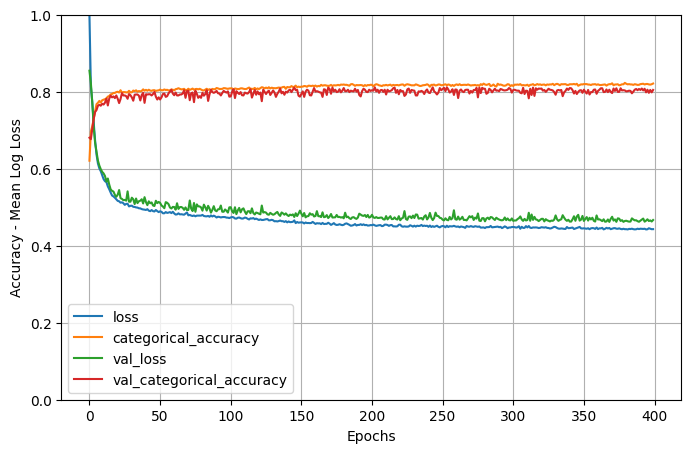

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Error (training): 17.87 %
Error (test): 19.54 %
Bias: 12.87
Variance: 1.67
Time:  263 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 2ms/step


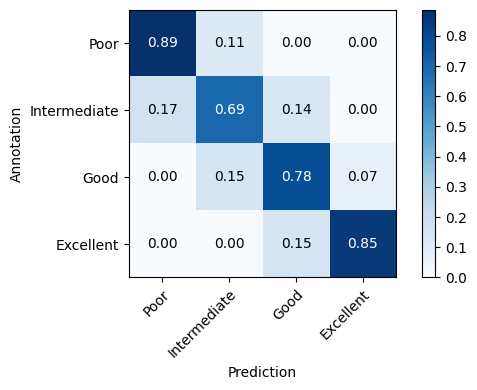

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [20]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM b109 b20999",
    "l2 0.001",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [22]:
last_five = results_df.tail(5)
#last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

      model_name  epochs  learning_rate  batch_size activation  \
41  D128_D64_D32     400          0.001         128       tanh   
42  D128_D64_D32     400          0.001         128       tanh   
43  D128_D64_D32     400          0.001         128       tanh   
44  D128_D64_D32     400          0.001         128       tanh   
45  D128_D64_D32     400          0.001         128       tanh   

                        loss         optimizer regularization  train_accuracy  \
41  categorical_crossentropy  ADAM b109 b20999       l2 0.001           81.95   
42  categorical_crossentropy  ADAM b109 b20999       l2 0.001           82.13   
43  categorical_crossentropy  ADAM b109 b20999       l2 0.001           82.13   
44  categorical_crossentropy  ADAM b109 b20999       l2 0.001           81.90   
45  categorical_crossentropy  ADAM b109 b20999       l2 0.001           81.77   

    validation_accuracy   bias  variance  training_time  
41                80.52  13.05      1.43            267  


In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-4.h5"
my_model.save(save_name)